In [1]:
# Cell 1: Notebook Setup and Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Display options for easier debugging
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)

In [2]:
# Cell 2: Load raw 1-min futures data (Soybean Oil and Soybean Meal)

# Define the path to the CSV using pathlib
data_path = Path("..") / "data" / "data_Y_M_1min.csv"

# Load CSV into a single DataFrame
raw_df = pd.read_csv(data_path)

# Convert 'datetime' column to pandas datetime type
raw_df['datetime'] = pd.to_datetime(raw_df['datetime'])

# Sort by contract ID and datetime for proper chronological order
raw_df = raw_df.sort_values(by=['order_book_id', 'datetime']).reset_index(drop=True)

# Preview the data
raw_df.head()

,order_book_id,datetime,trading_date,close,volume,low,high,total_turnover,open,open_interest
0,M2001,2020-01-02 09:01:00,2020-01-02,2632.0,150.0,2488.0,2632.0,3762210.0,2488.0,9818.0
1,M2001,2020-01-02 09:02:00,2020-01-02,2630.0,25.0,2630.0,2640.0,659500.0,2632.0,9818.0
2,M2001,2020-01-02 09:03:00,2020-01-02,2639.0,1.0,2630.0,2639.0,26390.0,2630.0,9818.0
3,M2001,2020-01-02 09:04:00,2020-01-02,2636.0,101.0,2636.0,2637.0,2663360.0,2637.0,9818.0
4,M2001,2020-01-02 09:05:00,2020-01-02,2640.0,23.0,2636.0,2640.0,606880.0,2636.0,9818.0


In [3]:
# Contract Universe by Product
raw_df['product'] = raw_df['order_book_id'].str[0]  # 'Y' or 'M'
print(raw_df.groupby('product')['order_book_id'].unique())

# Datetime Range per Contract
contract_lifespans = raw_df.groupby('order_book_id')['datetime'].agg(['min', 'max'])
print(contract_lifespans)

product
M    [M2001, M2003, M2005, M2007, M2008, M2009, M20...
Y    [Y2001, Y2003, Y2005, Y2007, Y2008, Y2009, Y20...
Name: order_book_id, dtype: object
                              min                 max
order_book_id                                        
M2001         2020-01-02 09:01:00 2020-01-15 15:00:00
M2003         2020-01-02 09:01:00 2020-03-13 15:00:00
M2005         2020-01-02 09:01:00 2020-05-19 15:00:00
M2007         2020-01-02 09:01:00 2020-07-14 15:00:00
M2008         2020-01-02 09:01:00 2020-08-14 15:00:00
...                           ...                 ...
Y2511         2024-11-14 21:01:00 2025-06-11 15:00:00
Y2512         2024-12-13 21:01:00 2025-06-11 15:00:00
Y2601         2025-01-15 21:01:00 2025-06-11 15:00:00
Y2603         2025-03-14 21:01:00 2025-06-11 15:00:00
Y2605         2025-05-19 21:01:00 2025-06-11 15:00:00

[102 rows x 2 columns]


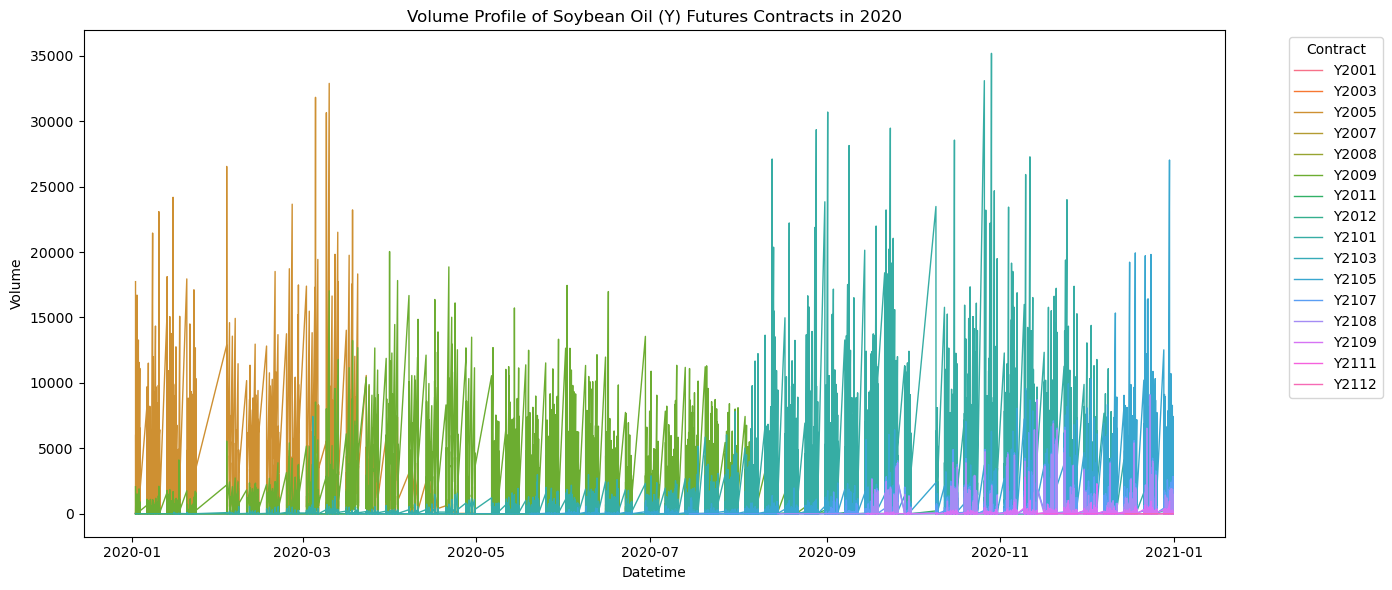

In [4]:
# Plot: Volume Profile for Y Contracts in 2020
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for Y contracts and only 2020 data
df_y_2020 = raw_df[
    (raw_df['order_book_id'].str.startswith('Y')) &
    (raw_df['datetime'].dt.year == 2020)
]

# Plot volume per contract
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_y_2020, x='datetime', y='volume', hue='order_book_id', linewidth=1)
plt.title("Volume Profile of Soybean Oil (Y) Futures Contracts in 2020")
plt.xlabel("Datetime")
plt.ylabel("Volume")
plt.legend(title="Contract", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
 

In [5]:
# Step 1: Extract unique contracts
unique_contracts = raw_df['order_book_id'].unique()
unique_contracts.sort()

print(unique_contracts[:10])  # Preview the first few contracts

['M2001' 'M2003' 'M2005' 'M2007' 'M2008' 'M2009' 'M2011' 'M2012' 'M2101'
 'M2103']


In [6]:
# Step 2: Parse order_book_id into product, expiry_year, and expiry_month

import re

# Function to parse an order_book_id like "M2001"
def parse_contract_id(contract_id):
    match = re.match(r"([A-Z]+)(\d{4})", contract_id)
    if match:
        product = match.group(1)
        year = 2000 + int(match.group(2)[:2])   # e.g., "20" → 2020
        month = int(match.group(2)[2:])         # e.g., "01" → January
        return product, year, month
    return None, None, None

# Parse all contracts into a DataFrame
parsed_contracts = pd.DataFrame(
    [parse_contract_id(cid) for cid in unique_contracts],
    columns=["product", "year", "month"]
)
parsed_contracts["order_book_id"] = unique_contracts

parsed_contracts.head()

,product,year,month,order_book_id
0,M,2020,1,M2001
1,M,2020,3,M2003
2,M,2020,5,M2005
3,M,2020,7,M2007
4,M,2020,8,M2008


In [7]:
# Filter to include only contracts that expire in January, May, or September
parsed_contracts = parsed_contracts[parsed_contracts["month"].isin([1, 5, 9])].copy()

# Sort to maintain chronological order
parsed_contracts = parsed_contracts.sort_values(["product", "year", "month"]).reset_index(drop=True)

In [8]:
# Step 3: Compute roll date = last day of the month TWO months BEFORE expiry month

from calendar import monthrange

def compute_roll_date(year, month):
    # Roll 2 months before expiry month
    if month <= 2:
        roll_year = year - 1
        roll_month = month + 10  # e.g. Jan → Nov (11), Feb → Dec (12)
    else:
        roll_year = year
        roll_month = month - 2

    # Get last calendar day of that month
    last_day = monthrange(roll_year, roll_month)[1]
    return pd.Timestamp(roll_year, roll_month, last_day)

# Apply to parsed_contracts
parsed_contracts["roll_date"] = parsed_contracts.apply(
    lambda row: compute_roll_date(row["year"], row["month"]),
    axis=1
)

# Preview the result
parsed_contracts.sort_values(["product", "roll_date"]).head()

,product,year,month,order_book_id,roll_date
0,M,2020,1,M2001,2019-11-30
1,M,2020,5,M2005,2020-03-31
2,M,2020,9,M2009,2020-07-31
3,M,2021,1,M2101,2020-11-30
4,M,2021,5,M2105,2021-03-31


In [9]:
# Step 4.1: Create stitched continuous 1-minute time series for a given product
def stitch_continuous_series(raw_df, contract_schedule, product):
    """
    Given the raw_df, contract schedule, and a product (e.g. 'Y' or 'M'),
    return a continuous time series stitched based on roll dates.
    """
    product_schedule = contract_schedule[contract_schedule["product"] == product].sort_values("roll_date")
    stitched = []

    for i in range(len(product_schedule)):
        current_row = product_schedule.iloc[i]
        current_id = current_row["order_book_id"]
        start_date = product_schedule.iloc[i - 1]["roll_date"] if i > 0 else None
        end_date = current_row["roll_date"]

        # Select data for current contract
        df_leg = raw_df[raw_df["order_book_id"] == current_id].copy()

        # Clip by roll schedule
        if start_date:
            df_leg = df_leg[df_leg["datetime"].dt.floor("D") > start_date]
        df_leg = df_leg[df_leg["datetime"].dt.floor("D") <= end_date]

        if df_leg.empty:
            continue  # Skip contracts with no usable data in window

        df_leg["stitched_order_book_id"] = current_id
        stitched.append(df_leg)

    stitched_df = pd.concat(stitched).sort_values("datetime").reset_index(drop=True)
    return stitched_df

In [10]:
# Step 4.2: Generate stitched continuous series for Y and M futures

# For Soybean Oil (Y)
Y_continuous_df = stitch_continuous_series(raw_df, parsed_contracts, product="Y")

# For Soybean Meal (M)
M_continuous_df = stitch_continuous_series(raw_df, parsed_contracts, product="M")

# Preview the stitched output for Y
Y_continuous_df.head()

,order_book_id,datetime,trading_date,close,volume,low,high,total_turnover,open,open_interest,product,stitched_order_book_id
0,Y2005,2020-01-02 09:01:00,2020-01-02,6746.0,17735.0,6712.0,6750.0,1.193869e+09,6722.0,662395.0,Y,Y2005
1,Y2005,2020-01-02 09:02:00,2020-01-02,6748.0,6095.0,6746.0,6756.0,4.114961e+08,6746.0,662604.0,Y,Y2005
2,Y2005,2020-01-02 09:03:00,2020-01-02,6746.0,6516.0,6738.0,6750.0,4.393400e+08,6750.0,661900.0,Y,Y2005
3,Y2005,2020-01-02 09:04:00,2020-01-02,6758.0,3432.0,6744.0,6758.0,2.317446e+08,6746.0,661794.0,Y,Y2005
4,Y2005,2020-01-02 09:05:00,2020-01-02,6760.0,4491.0,6758.0,6762.0,3.035690e+08,6758.0,662319.0,Y,Y2005


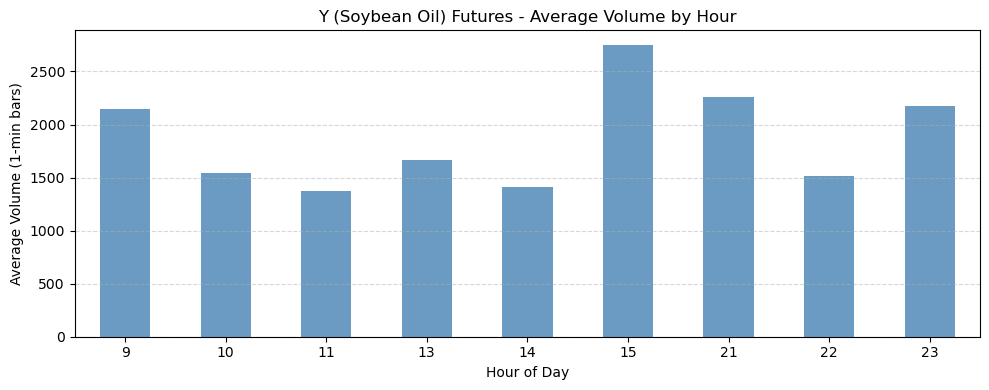

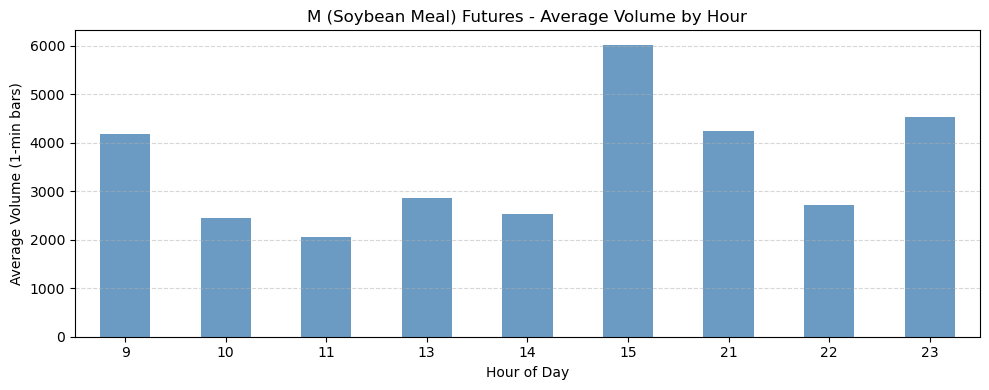

In [11]:
import matplotlib.pyplot as plt

def plot_volume_profile(df, product_name):
    # Extract hour from datetime
    df['hour'] = df['datetime'].dt.hour

    # Compute average volume per hour
    volume_profile = df.groupby('hour')['volume'].mean()

    # Plot
    plt.figure(figsize=(10, 4))
    volume_profile.plot(kind='bar', color='steelblue', alpha=0.8)
    plt.title(f"{product_name} Futures - Average Volume by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Volume (1-min bars)")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot volume profiles for Y and M
plot_volume_profile(Y_continuous_df.copy(), "Y (Soybean Oil)")
plot_volume_profile(M_continuous_df.copy(), "M (Soybean Meal)")

In [12]:
import re

def extract_expiry_month(order_book_id):
    match = re.search(r'(\d{4})$', order_book_id)
    if match:
        expiry_code = match.group(1)
        return int(expiry_code[-2:])  # Last 2 digits are month
    return None

# Apply to Y_continuous_df
Y_continuous_df["expiry_month"] = Y_continuous_df["stitched_order_book_id"].apply(extract_expiry_month)

# Apply to M_continuous_df as well
M_continuous_df["expiry_month"] = M_continuous_df["stitched_order_book_id"].apply(extract_expiry_month)

In [13]:
Y_continuous_df.head()

,order_book_id,datetime,trading_date,close,volume,low,high,total_turnover,open,open_interest,product,stitched_order_book_id,expiry_month
0,Y2005,2020-01-02 09:01:00,2020-01-02,6746.0,17735.0,6712.0,6750.0,1.193869e+09,6722.0,662395.0,Y,Y2005,5
1,Y2005,2020-01-02 09:02:00,2020-01-02,6748.0,6095.0,6746.0,6756.0,4.114961e+08,6746.0,662604.0,Y,Y2005,5
2,Y2005,2020-01-02 09:03:00,2020-01-02,6746.0,6516.0,6738.0,6750.0,4.393400e+08,6750.0,661900.0,Y,Y2005,5
3,Y2005,2020-01-02 09:04:00,2020-01-02,6758.0,3432.0,6744.0,6758.0,2.317446e+08,6746.0,661794.0,Y,Y2005,5
4,Y2005,2020-01-02 09:05:00,2020-01-02,6760.0,4491.0,6758.0,6762.0,3.035690e+08,6758.0,662319.0,Y,Y2005,5


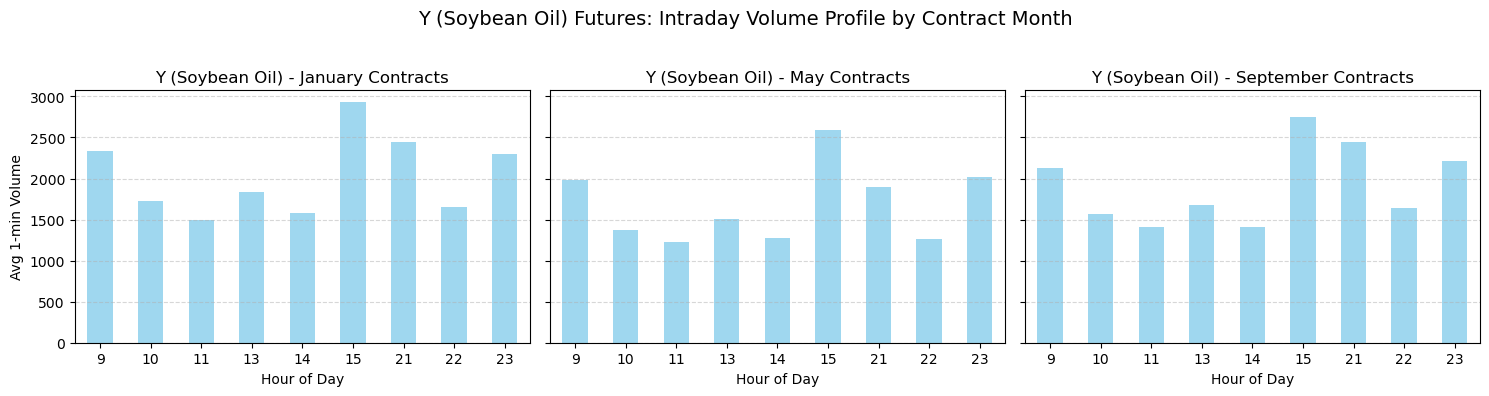

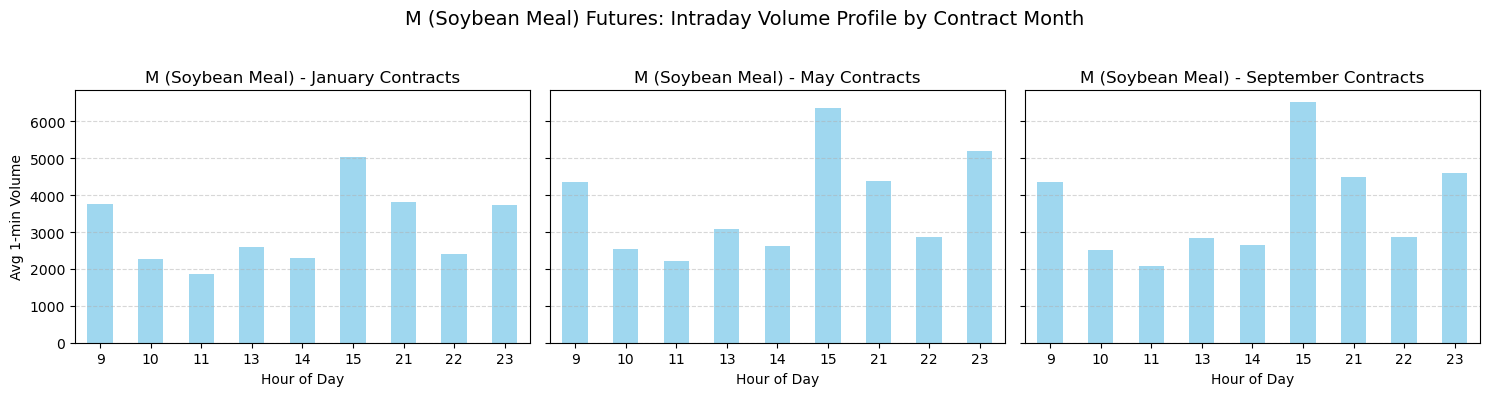

In [14]:
def plot_volume_profile_by_month(df, product_name):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    contract_months = [1, 5, 9]
    month_labels = {1: "January", 5: "May", 9: "September"}

    for i, month in enumerate(contract_months):
        sub_df = df[df["expiry_month"] == month].copy()
        sub_df["hour"] = sub_df["datetime"].dt.hour
        volume_profile = sub_df.groupby("hour")["volume"].mean()

        volume_profile.plot(kind="bar", ax=axes[i], color="skyblue", alpha=0.8)
        axes[i].set_title(f"{product_name} - {month_labels[month]} Contracts")
        axes[i].set_xlabel("Hour of Day")
        if i == 0:
            axes[i].set_ylabel("Avg 1-min Volume")
        axes[i].grid(axis="y", linestyle="--", alpha=0.5)
        axes[i].tick_params(axis='x', rotation=0)

    plt.suptitle(f"{product_name} Futures: Intraday Volume Profile by Contract Month", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Run for Y
plot_volume_profile_by_month(Y_continuous_df, product_name="Y (Soybean Oil)")
 
# Run for M
plot_volume_profile_by_month(M_continuous_df, product_name="M (Soybean Meal)")


In [15]:
# Extract calendar year from datetime
Y_continuous_df["year"] = Y_continuous_df["datetime"].dt.year
M_continuous_df["year"] = M_continuous_df["datetime"].dt.year

In [16]:
def plot_volume_profile_by_year(df, product_name):
    fig, axes = plt.subplots(2, 3, figsize=(18, 6), sharey=True)
    axes = axes.flatten()

    years = sorted(df["year"].dropna().unique())

    for i, year in enumerate(years):
        sub_df = df[df["year"] == year].copy()
        sub_df["hour"] = sub_df["datetime"].dt.hour
        volume_profile = sub_df.groupby("hour")["volume"].mean()

        volume_profile.plot(kind="bar", ax=axes[i], color="salmon", alpha=0.8)
        axes[i].set_title(f"{product_name} - {year}")
        axes[i].set_xlabel("Hour")
        if i % 3 == 0:
            axes[i].set_ylabel("Avg 1-min Volume")
        axes[i].grid(axis="y", linestyle="--", alpha=0.5)
        axes[i].tick_params(axis='x', rotation=0)

    plt.suptitle(f"{product_name} Futures: Intraday Volume Profile by Calendar Year", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

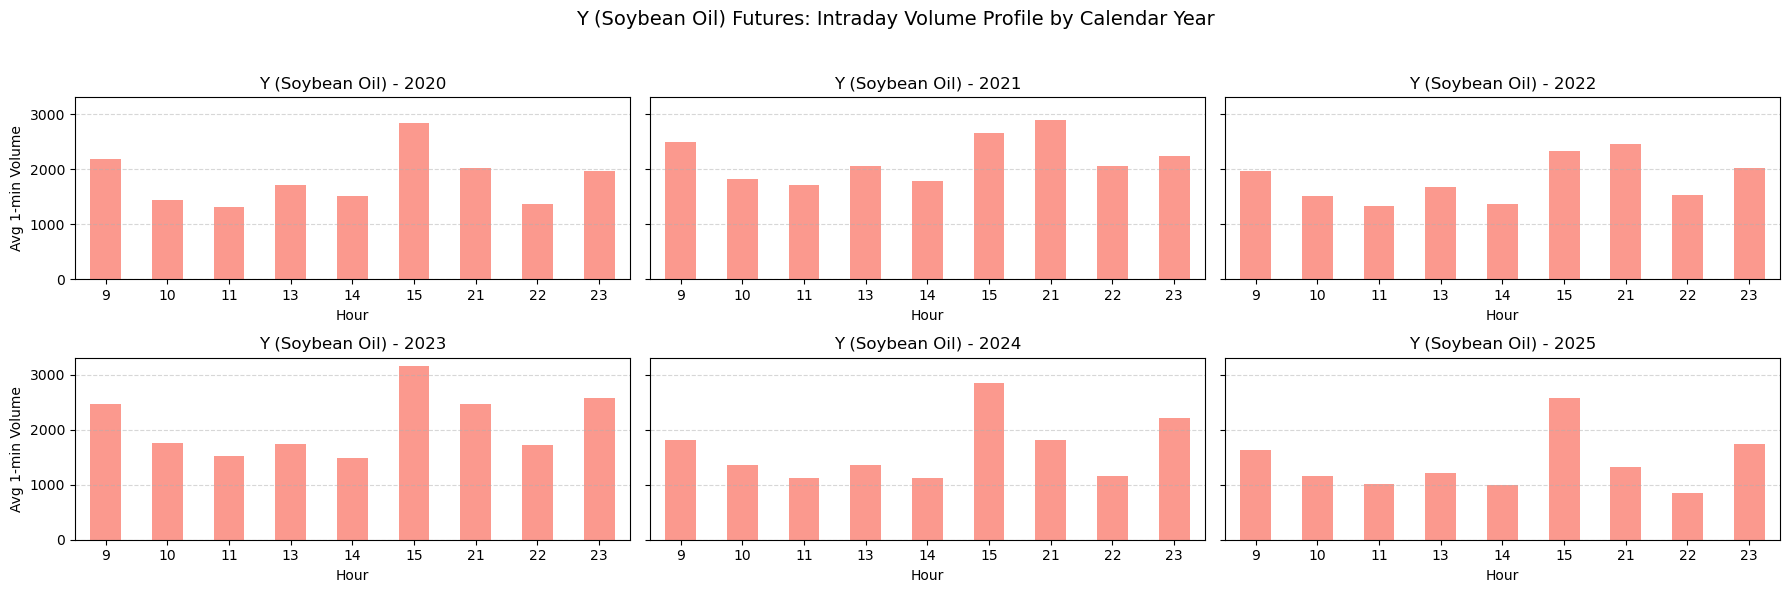

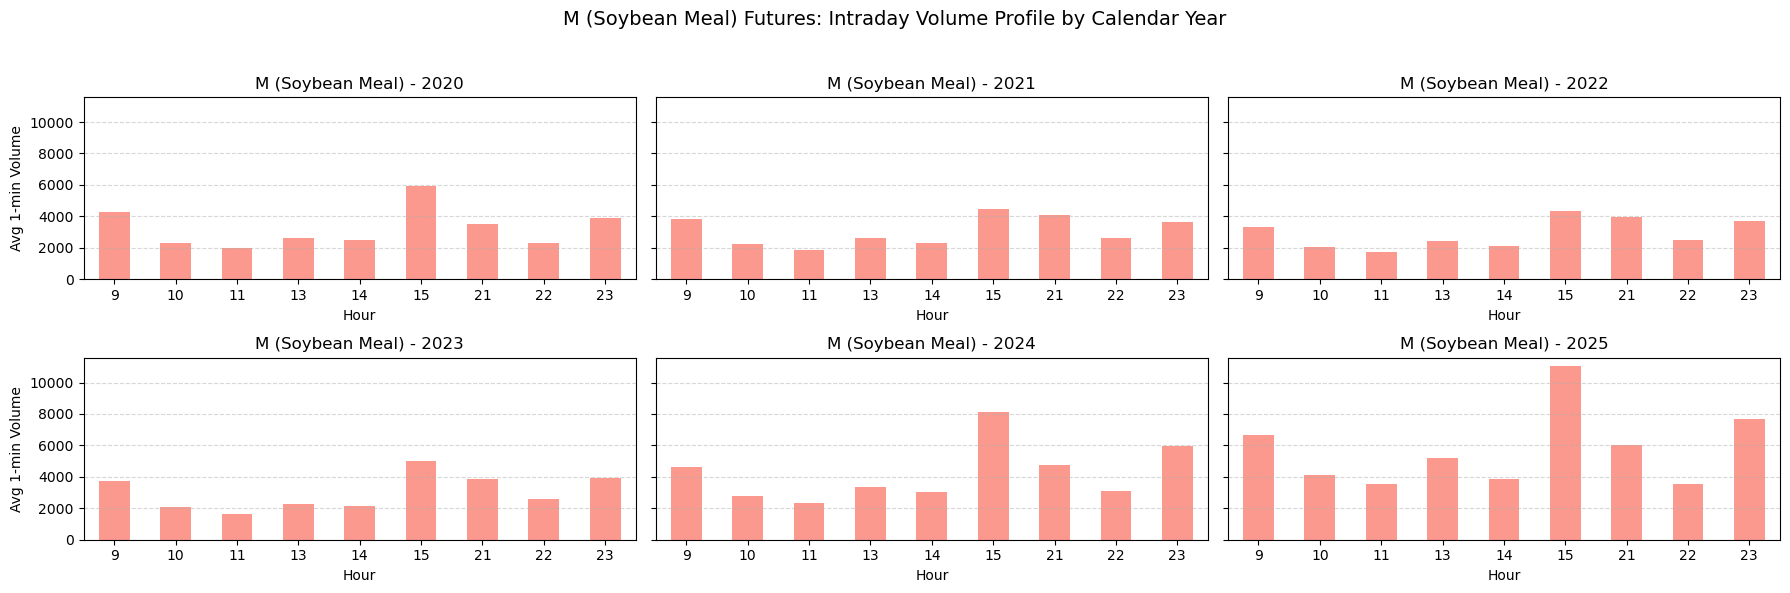

In [17]:
# Plot for Soybean Oil (Y)
plot_volume_profile_by_year(Y_continuous_df.copy(), product_name="Y (Soybean Oil)")

# Plot for Soybean Meal (M)
plot_volume_profile_by_year(M_continuous_df.copy(), product_name="M (Soybean Meal)")

In [18]:
# Define the set of relevant features
columns_to_keep = [
    "datetime", "trading_date", "close", "volume", "low", "high", "total_turnover", "open", "open_interest"
]

# Merge Y and M continuous DataFrames on datetime
merged_df = pd.merge(
    Y_continuous_df[columns_to_keep],
    M_continuous_df[columns_to_keep],
    on="datetime",
    how="inner",
    suffixes=("_Y", "_M")
)

# Preview result
merged_df.head()

,datetime,trading_date_Y,close_Y,volume_Y,low_Y,high_Y,total_turnover_Y,open_Y,open_interest_Y,trading_date_M,close_M,volume_M,low_M,high_M,total_turnover_M,open_M,open_interest_M
0,2020-01-02 09:01:00,2020-01-02,6746.0,17735.0,6712.0,6750.0,1.193869e+09,6722.0,662395.0,2020-01-02,2780.0,20247.0,2778.0,2782.0,562833510.0,2780.0,1688619.0
1,2020-01-02 09:02:00,2020-01-02,6748.0,6095.0,6746.0,6756.0,4.114961e+08,6746.0,662604.0,2020-01-02,2779.0,7854.0,2778.0,2781.0,218305110.0,2780.0,1688123.0
2,2020-01-02 09:03:00,2020-01-02,6746.0,6516.0,6738.0,6750.0,4.393400e+08,6750.0,661900.0,2020-01-02,2782.0,6526.0,2779.0,2783.0,181441130.0,2779.0,1688507.0
3,2020-01-02 09:04:00,2020-01-02,6758.0,3432.0,6744.0,6758.0,2.317446e+08,6746.0,661794.0,2020-01-02,2784.0,8699.0,2782.0,2784.0,242043320.0,2783.0,1688491.0
4,2020-01-02 09:05:00,2020-01-02,6760.0,4491.0,6758.0,6762.0,3.035690e+08,6758.0,662319.0,2020-01-02,2785.0,12681.0,2783.0,2786.0,353090420.0,2783.0,1688722.0


In [19]:
# Step 1: Extract datetime and stitched_order_book_id for Y and M legs
Y_contract_ids = Y_continuous_df[["datetime", "stitched_order_book_id"]].rename(
    columns={"stitched_order_book_id": "contract_Y"}
)
M_contract_ids = M_continuous_df[["datetime", "stitched_order_book_id"]].rename(
    columns={"stitched_order_book_id": "contract_M"}
)

# Step 2: Merge contract IDs into merged_df
merged_df = merged_df.merge(Y_contract_ids, on="datetime", how="left")
merged_df = merged_df.merge(M_contract_ids, on="datetime", how="left")

# STEP: Add roll_date_Y to merged_df
roll_map = parsed_contracts[parsed_contracts["product"] == "Y"][
    ["order_book_id", "roll_date"]
].rename(columns={
    "order_book_id": "contract_Y",
    "roll_date": "roll_date_Y"
})
merged_df = merged_df.merge(roll_map, on="contract_Y", how="left")

# Compute actual last trading day per contract_Y
actual_last_dates = (
    merged_df.groupby("contract_Y", observed=True)["datetime"]
    .max()
    .dt.floor("D")
    .reset_index()
    .rename(columns={"datetime": "actual_roll_date"})
)
# Merge into main dataframe
merged_df = merged_df.merge(actual_last_dates, on="contract_Y", how="left")

# Define is_roll_date based on actual last trading day (not theoretical roll_date_Y)
merged_df["is_roll_date"] = (
    merged_df["datetime"].dt.floor("D") == merged_df["actual_roll_date"]
)

# --- Compute gap_days_to_next at daily level ---
df_day = merged_df[["datetime"]].copy()
df_day["date"] = df_day["datetime"].dt.normalize()
df_day = df_day.drop_duplicates("date").sort_values("date").reset_index(drop=True)

df_day["next_trading_date"] = df_day["date"].shift(-1)
df_day["gap_days_to_next"] = (df_day["next_trading_date"] - df_day["date"]).dt.days
df_day["gap_days_to_next"] = df_day["gap_days_to_next"].fillna(np.inf)

# Merge back into minute-level merged_df
merged_df["trading_date"] = merged_df["datetime"].dt.normalize()
merged_df = merged_df.merge(
    df_day[["date", "gap_days_to_next"]].rename(columns={"date": "trading_date"}),
    on="trading_date",
    how="left"
)

# Add contract Y group id: every time contract_Y changes, increment the group
merged_df["contract_Y_group"] = (merged_df["contract_Y"] != merged_df["contract_Y"].shift()).cumsum()

# Add price ratio features
merged_df["price_ratio"] = merged_df["close_Y"] / merged_df["close_M"]
merged_df["log_price_ratio"] = np.log(merged_df["close_Y"]) - np.log(merged_df["close_M"])

# Preview result
merged_df[["datetime", "contract_Y", "contract_M", "roll_date_Y", "is_roll_date", "trading_date", "gap_days_to_next", "contract_Y_group", "price_ratio", "log_price_ratio"]].head()

,datetime,contract_Y,contract_M,roll_date_Y,is_roll_date,trading_date,gap_days_to_next,contract_Y_group,price_ratio,log_price_ratio
0,2020-01-02 09:01:00,Y2005,M2005,2020-03-31,False,2020-01-02,1.0,1,2.426619,0.886499
1,2020-01-02 09:02:00,Y2005,M2005,2020-03-31,False,2020-01-02,1.0,1,2.428212,0.887155
2,2020-01-02 09:03:00,Y2005,M2005,2020-03-31,False,2020-01-02,1.0,1,2.424874,0.885780
3,2020-01-02 09:04:00,Y2005,M2005,2020-03-31,False,2020-01-02,1.0,1,2.427443,0.886838
4,2020-01-02 09:05:00,Y2005,M2005,2020-03-31,False,2020-01-02,1.0,1,2.427289,0.886775


In [20]:
# ================================
# spread_backtest_YM_engine.ipynb — Next Cell After merge_df
# ================================

# --- Imports ---
import numpy as np
import pandas as pd

from spread_backtest_engine import (
    compute_rolling_zscore_grouped,
    generate_trading_signals_directional,
    run_backtest_loop,
    compute_trading_metrics
)

# --- Configurable Parameters ---
ZSCORE_WINDOW = 60  # rolling window in minutes
ENTRY_THRESHOLD_LONG = -1.5
ENTRY_THRESHOLD_SHORT = 1.5
EXIT_THRESHOLD_LONG = 0.0
EXIT_THRESHOLD_SHORT = 0.0

EXECUTION_CONFIG = {
    "entry_execution_price": "open",
    "exit_execution_price": "open",
    "execution_lag": 1,
    "stop_loss_pct": None, # 0.02 / None
    "max_holding_minutes": None, # 60 / None
    "max_gap_days": 3
}

# --- Step 1: Z-Score Computation ---
merged_df["zscore"] = compute_rolling_zscore_grouped(
    df=merged_df,
    value_col="log_price_ratio",
    window=ZSCORE_WINDOW,
    group_col="contract_Y_group"
)

# --- Step 2: Signal Generation ---
merged_df["position_signal"], merged_df["raw_signal"] = generate_trading_signals_directional(
    zscore_series=merged_df["zscore"],
    entry_threshold_long=ENTRY_THRESHOLD_LONG,
    entry_threshold_short=ENTRY_THRESHOLD_SHORT,
    exit_threshold_long=EXIT_THRESHOLD_LONG,
    exit_threshold_short=EXIT_THRESHOLD_SHORT
)

# --- Step 3: Backtest Execution ---
df_result, trade_data = run_backtest_loop(
    df=merged_df,
    signal_col="raw_signal",
    execution_config=EXECUTION_CONFIG
)

# --- Step 4: Derive Trade Directions ---
if df_result["trade_id"].notna().any():
    trade_directions = (
        df_result[df_result["trade_id"].notna()]
        .groupby("trade_id", observed=True)["executed_position"]
        .first()
        .astype(int)
        .tolist()
    )
else:
    trade_directions = []

# --- Step 5: Compute Metrics ---
metrics = compute_trading_metrics(df_result, trade_data, trade_directions)
assert len(trade_data["trade_log_returns"]) == len(trade_directions), \
    "Mismatch between trade returns and trade directions"

# --- Step 6: Output Summary ---
# DataFrame view for analysis/copying
metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["value"]).sort_index()
print("\n=== Summary Trading Metrics (DataFrame View) ===")
display(metrics_df)

# Pretty-printed view for readability
print("\n=== Summary Trading Metrics (Pretty Print) ===")
for key in sorted(metrics.keys()):
    value = metrics[key]
    if isinstance(value, float):
        print(f"{key:30s}: {value:,.4f}")
    else:
        print(f"{key:30s}: {value}")
# metrics_df.to_csv("metrics_summary.csv")  # for saving to file


=== Summary Trading Metrics (DataFrame View) ===


,value
annualized_return,0.178688
avg_holding_minutes,31.603124
avg_long_trade_return,0.000108
avg_short_trade_return,0.000095
avg_trade_return,0.000101
cumulative_log_return,0.836078
date_of_max_drawdown,2021-05-19 10:15:00
expectancy,0.000095
long_win_rate,0.711281
max_consecutive_losses,7



=== Summary Trading Metrics (Pretty Print) ===
annualized_return             : 0.1787
avg_holding_minutes           : 31.6031
avg_long_trade_return         : 0.0001
avg_short_trade_return        : 0.0001
avg_trade_return              : 0.0001
cumulative_log_return         : 0.8361
date_of_max_drawdown          : 2021-05-19 10:15:00
expectancy                    : 0.0001
long_win_rate                 : 0.7113
max_consecutive_losses        : 7
max_drawdown                  : -0.2138
median_trade_return           : 0.0013
num_long_trades               : 4565
num_short_trades              : 4589
num_trades                    : 9154
profit_factor                 : 1.0724
sharpe_ratio                  : 0.8851
short_win_rate                : 0.7058
sortino_ratio                 : 1.0010
std_trade_return              : 0.0045
total_return                  : 1.3073
win_rate                      : 0.7085


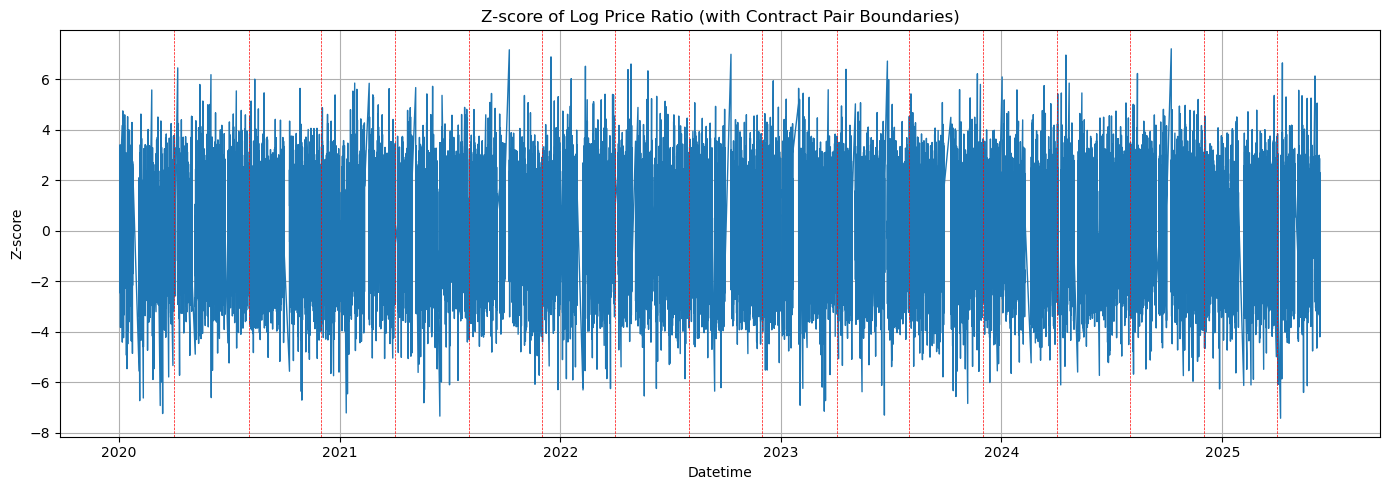

In [21]:
import matplotlib.pyplot as plt

# Step 4: Visualize z-score of log ratio across time
plt.figure(figsize=(14, 5))
plt.plot(merged_df["datetime"], merged_df["zscore"], label="Z-score (log ratio)", color="tab:blue", linewidth=1)

# Mark roll boundaries where contract_Y or contract_M changes
contract_change = (
    ((merged_df["contract_Y"] != merged_df["contract_Y"].shift()) |
    (merged_df["contract_M"] != merged_df["contract_M"].shift()))
    & (merged_df.index != 0)  # Avoid first row
)
for ts in merged_df.loc[contract_change, "datetime"]:
    plt.axvline(ts, color='red', linestyle='--', linewidth=0.5)

plt.title("Z-score of Log Price Ratio (with Contract Pair Boundaries)")
plt.xlabel("Datetime")
plt.ylabel("Z-score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Compute equity curve from strategy_log_return

import matplotlib.pyplot as plt

# Step 1: Cumulative log return
df_result["cumulative_log_return"] = df_result["strategy_log_return"].cumsum()

# Step 2: Convert log return to percentage cumulative return
df_result["equity_curve"] = np.exp(df_result["cumulative_log_return"]) - 1

                 datetime  close_Y  close_M    zscore       pnl
77515 2021-01-08 22:56:00   8136.0   3538.0 -2.063795  0.000135
77516 2021-01-08 22:57:00   8140.0   3532.0 -0.436977  0.002189
77517 2021-01-08 22:58:00   8144.0   3532.0 -0.088407  0.000491
77518 2021-01-08 22:59:00   8144.0   3532.0 -0.104040  0.000000
77519 2021-01-08 23:00:00   8138.0   3530.0 -0.256524 -0.000171
77520 2021-01-11 09:01:00   8158.0   3643.0 -7.215438 -0.029055
77521 2021-01-11 09:02:00   8170.0   3634.0 -4.779610  0.003943
77522 2021-01-11 09:03:00   8176.0   3618.0 -3.342480  0.005147
77523 2021-01-11 09:04:00   8170.0   3611.0 -2.854629  0.001203
77524 2021-01-11 09:05:00   8180.0   3604.0 -2.202967  0.003164
77525 2021-01-11 09:06:00   8174.0   3610.0 -2.399892 -0.002397


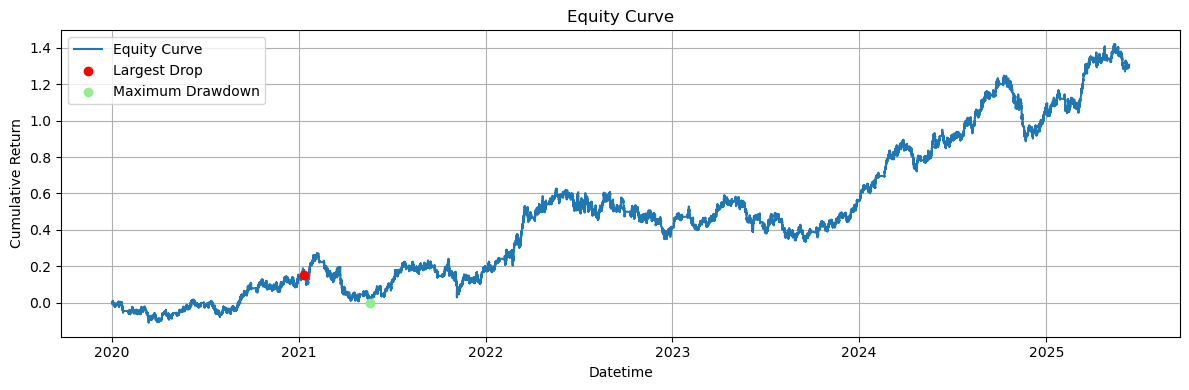

In [23]:
# Find the Largest 1-Bar Drop in Log Return

# Compute per-bar PnL (already strategy_log_return), but double check
df_result["pnl"] = df_result["strategy_log_return"]

# Find row with largest *negative* pnl
max_drop_idx = df_result["pnl"].idxmin()

# Find idex of max drawdown
date_of_max_dd = metrics["date_of_max_drawdown"]
max_drawdown_idx = df_result.index[df_result["datetime"] == date_of_max_dd][0] if date_of_max_dd else None

# Show row and ±5 minutes around it for context
print(df_result.loc[max(0, max_drop_idx - 5): max_drop_idx + 5, ["datetime", "close_Y", "close_M", "zscore", "pnl"]])

# Visualize where the drop occurred
plt.figure(figsize=(12, 4))
plt.plot(df_result["datetime"], df_result["equity_curve"], label="Equity Curve")
plt.scatter(df_result.loc[max_drop_idx, "datetime"], df_result.loc[max_drop_idx, "equity_curve"], color="red", label="Largest Drop", zorder=5)
plt.scatter(df_result.loc[max_drawdown_idx, "datetime"], df_result.loc[max_drawdown_idx, "equity_curve"], color="lightgreen", label="Maximum Drawdown", zorder=5)
plt.title("Equity Curve")
plt.xlabel("Datetime")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# ================================
# Define the Parameter Grid
# ================================

from itertools import product
import copy

# --- Signal Parameter Grid ---
ZSCORE_WINDOWS = [60]                              # Rolling window in minutes
ENTRY_LONGS = [-1.5]                         # Long entry thresholds
ENTRY_SHORTS = [1.5]                          # Short entry thresholds
EXIT_LONGS = [0.0]                                # Long exit thresholds
EXIT_SHORTS = [0.0]                                # Short exit thresholds

# --- Execution Parameter Grid ---
ENTRY_EXEC_PRICES = ["open"]                      # Entry price (e.g., "open", "close")
EXIT_EXEC_PRICES = ["open"]                       # Exit price
EXEC_LAG = [1]                                    # Execution lag in minutes
STOP_LOSS_PCTS = [None]                     # Stop loss (None or e.g. 0.02)
MAX_HOLD_MINUTES = [None]                     # Max holding duration
MAX_DAY_GAP = [3]                              # Max gap days allowed between trades

# --- Combine all combinations into a single list of configs ---
param_grid = []

for zwin, el, es, exl, exs, eep, exp, elg, sl, mh, mdg in product(
    ZSCORE_WINDOWS, ENTRY_LONGS, ENTRY_SHORTS, EXIT_LONGS, EXIT_SHORTS,
    ENTRY_EXEC_PRICES, EXIT_EXEC_PRICES, EXEC_LAG, STOP_LOSS_PCTS, MAX_HOLD_MINUTES, MAX_DAY_GAP
):
    config = {
        "signal": {
            "zscore_window": zwin,
            "entry_threshold_long": el,
            "entry_threshold_short": es,
            "exit_threshold_long": exl,
            "exit_threshold_short": exs
        },
        "execution": {
            "entry_execution_price": eep,
            "exit_execution_price": exp,
            "execution_lag": elg,
            "stop_loss_pct": sl,
            "max_holding_minutes": mh,
            "max_gap_days": mdg
        }
    }
    param_grid.append(config)

print(f"Total parameter combinations: {len(param_grid)}")

from pprint import pprint
pprint(param_grid[:3])

Total parameter combinations: 1
[{'execution': {'entry_execution_price': 'open',
                'execution_lag': 1,
                'exit_execution_price': 'open',
                'max_gap_days': 3,
                'max_holding_minutes': None,
                'stop_loss_pct': None},
  'signal': {'entry_threshold_long': -1.5,
             'entry_threshold_short': 1.5,
             'exit_threshold_long': 0.0,
             'exit_threshold_short': 0.0,
             'zscore_window': 60}}]


In [25]:
# ================================
# Define run_backtest_for_config function
# ================================
"""
This helper function takes a merged minute-level DataFrame and a configuration (config) dictionary containing signal and execution parameters,
runs the signal generation + backtest loop + metrics, and returns results.
"""
from spread_backtest_engine import (
    compute_rolling_zscore_grouped,
    generate_trading_signals_directional,
    run_backtest_loop,
    compute_trading_metrics
)

def run_backtest_for_config(merged_df, config):
    """
    Run full pipeline for a single parameter config.

    Parameters:
        merged_df (pd.DataFrame): Merged data with price columns, already preprocessed
        config (dict): Dict with 'signal' and 'execution' sub-dicts

    Returns:
        dict: Contains config, metrics, df_result, trade_data
    """
    signal_params = config["signal"]
    exec_params = config["execution"]
    zscore_window = signal_params["zscore_window"]

    # 1. Compute rolling z-score
    merged_df["zscore"] = compute_rolling_zscore_grouped(
        merged_df,
        value_col="log_price_ratio",
        window=zscore_window,
        group_col="contract_Y_group"
    )

    # 2. Generate trading signal
    merged_df["position_signal"], merged_df["raw_signal"] = generate_trading_signals_directional(
        merged_df["zscore"],
        entry_threshold_long=signal_params["entry_threshold_long"],
        entry_threshold_short=signal_params["entry_threshold_short"],
        exit_threshold_long=signal_params["exit_threshold_long"],
        exit_threshold_short=signal_params["exit_threshold_short"]
    )

    # 3. Run backtest
    df_result, trade_data = run_backtest_loop(
        merged_df,
        signal_col="raw_signal",  # ← we agreed this is the correct column
        execution_config=exec_params
    )

    # 4. Compute trade directions (for metrics)
    if df_result["trade_id"].notna().any():
        trade_directions = (
            df_result[df_result["trade_id"].notna()]
            .groupby("trade_id", observed=True)["executed_position"]
            .first()
            .astype(int)
            .tolist()
        )
    else:
        trade_directions = []

    # 5. Compute metrics
    metrics = compute_trading_metrics(df_result, trade_data, trade_directions)

    return {
        "config": config,
        "metrics": metrics,
        "df_result": df_result,
        "trade_data": trade_data
    }


In [26]:
# ================================
# Run Grid Search Over Parameter Grid
# ================================

from tqdm.notebook import tqdm

grid_results = []  # Store all results

print(f"Running grid search over {len(param_grid)} configurations...\n")

for config in tqdm(param_grid):
    try:
        result = run_backtest_for_config(merged_df.copy(), config)
        grid_results.append(result)
    except Exception as e:
        print(f"Error with config: {config}")
        print(e)

Running grid search over 1 configurations...



  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
# ================================
# Assemble Metrics into Results DataFrame
# ================================

results_records = []

for res in grid_results:
    record = {
        "config": res["config"],                   # <— retain raw config dict
        **res["config"]["signal"],                 # <— flattened for display/sorting
        **res["config"]["execution"],
        **res["metrics"]
    }
    results_records.append(record)

# Convert to DataFrame
results_df = pd.DataFrame(results_records)
print(f"\nConstructed results_df with shape: {results_df.shape}")
display(results_df.head())


Constructed results_df with shape: (1, 34)


,config,zscore_window,entry_threshold_long,entry_threshold_short,exit_threshold_long,exit_threshold_short,entry_execution_price,exit_execution_price,execution_lag,stop_loss_pct,max_holding_minutes,max_gap_days,sharpe_ratio,sortino_ratio,max_drawdown,num_trades,win_rate,avg_trade_return,avg_holding_minutes,total_return,cumulative_log_return,annualized_return,median_trade_return,std_trade_return,profit_factor,expectancy,max_consecutive_losses,date_of_max_drawdown,avg_long_trade_return,avg_short_trade_return,long_win_rate,short_win_rate,num_long_trades,num_short_trades
0,"{'signal': {'zscore_window': 60, 'entry_thresh...",60,-1.5,1.5,0.0,0.0,open,open,1,None,None,3,0.885123,1.000957,-0.213798,9154,0.708543,0.000101,31.603124,1.3073,0.836078,0.178688,0.001297,0.004485,1.072389,0.000095,7,2021-05-19 10:15:00,0.000108,0.000095,0.711281,0.705818,4565,4589


In [28]:
# ================================
# Step 2.4.1 — Define Evaluation Metrics for Voting
# ================================

# Format: (metric_name, higher_is_better)
evaluation_metrics = [
    ("sharpe_ratio", True),
    ("sortino_ratio", True),
    ("max_drawdown", True),
    ("win_rate", True),
    ("avg_trade_return", True),
    ("annualized_return", True),
]

In [29]:
# ================================
# Rank-Based Voting Evaluation (Updated)
# ================================

ranked_df = results_df.copy()

# Compute ranks per metric (lower rank is better)
for metric, higher_is_better in evaluation_metrics:
    ascending = not higher_is_better # invert for higher_is_better
    ranked_df[f"{metric}_rank"] = ranked_df[metric].rank(ascending=ascending, method="min")

# Compute total rank score (sum of all metric ranks)
rank_cols = [f"{metric}_rank" for metric, _ in evaluation_metrics]
ranked_df["total_rank_score"] = ranked_df[rank_cols].sum(axis=1)

# Sort by total_rank_score to find top configs (lower is better)
ranked_df = ranked_df.sort_values("total_rank_score").reset_index(drop=True)

# Robust dynamic extraction from ranked_df
signal_cols = list(ranked_df["config"].iloc[0]["signal"].keys())
execution_cols = list(ranked_df["config"].iloc[0]["execution"].keys())
param_cols = signal_cols + execution_cols

# === Show top-ranked configurations ===
print("\n=== Top Ranked Parameter Configs (by Voting) ===")
display(ranked_df[["total_rank_score"] + rank_cols + param_cols].head(5))


=== Top Ranked Parameter Configs (by Voting) ===


,total_rank_score,sharpe_ratio_rank,sortino_ratio_rank,max_drawdown_rank,win_rate_rank,avg_trade_return_rank,annualized_return_rank,zscore_window,entry_threshold_long,entry_threshold_short,exit_threshold_long,exit_threshold_short,entry_execution_price,exit_execution_price,execution_lag,stop_loss_pct,max_holding_minutes,max_gap_days
0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,60,-1.5,1.5,0.0,0.0,open,open,1,None,None,3


In [30]:
# ================================
# Step 2.4.3 — Extract Best Config for Walk-Forward
# ================================

# Get best config dictionary from top-ranked row
best_config = ranked_df.loc[0, "config"]

# Optional: Pretty print for inspection
from pprint import pprint
print("=== Best Parameter Configuration (Selected for Walk-Forward) ===")
pprint(best_config)

=== Best Parameter Configuration (Selected for Walk-Forward) ===
{'execution': {'entry_execution_price': 'open',
               'execution_lag': 1,
               'exit_execution_price': 'open',
               'max_gap_days': 3,
               'max_holding_minutes': None,
               'stop_loss_pct': None},
 'signal': {'entry_threshold_long': -1.5,
            'entry_threshold_short': 1.5,
            'exit_threshold_long': 0.0,
            'exit_threshold_short': 0.0,
            'zscore_window': 60}}


In [31]:
# ================================
# Step 2.6.1 — Identify Stitched Contract Groups
# ================================

group_ids = sorted(merged_df["contract_Y_group"].unique())
print(f"Found {len(group_ids)} stitched contract groups: {group_ids}")

Found 17 stitched contract groups: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


In [32]:
# ================================
# Step 2.6.2 — Walk-Forward Loop Setup
# ================================

walkforward_summary = []   # To store per-period configs and metrics
all_walkforward_df_results = []  # To accumulate df_result per walk-forward period

# Loop from second group onward
for i in range(1, len(group_ids)):
    train_group = group_ids[i - 1]
    test_group = group_ids[i]

    print(f"\n▶️ Walk-forward iteration: Train on group {train_group}, test on group {test_group}")

    # Subset train and test dataframes
    train_df = merged_df[merged_df["contract_Y_group"] == train_group].copy()
    test_df = merged_df[merged_df["contract_Y_group"] == test_group].copy()

    # Placeholder — to be filled step-by-step
    # best_config = ???
    # df_result, trade_data, metrics = ???

    # Store results for this period (will be updated step-by-step)
    walkforward_summary.append({
        "train_group": train_group,
        "test_group": test_group,
        # "best_config": best_config,
        # "metrics": metrics,
    })

    # if df_result is not None:
    #     all_walkforward_df_results.append(df_result)


▶️ Walk-forward iteration: Train on group 1, test on group 2

▶️ Walk-forward iteration: Train on group 2, test on group 3

▶️ Walk-forward iteration: Train on group 3, test on group 4

▶️ Walk-forward iteration: Train on group 4, test on group 5

▶️ Walk-forward iteration: Train on group 5, test on group 6

▶️ Walk-forward iteration: Train on group 6, test on group 7

▶️ Walk-forward iteration: Train on group 7, test on group 8

▶️ Walk-forward iteration: Train on group 8, test on group 9

▶️ Walk-forward iteration: Train on group 9, test on group 10

▶️ Walk-forward iteration: Train on group 10, test on group 11

▶️ Walk-forward iteration: Train on group 11, test on group 12

▶️ Walk-forward iteration: Train on group 12, test on group 13

▶️ Walk-forward iteration: Train on group 13, test on group 14

▶️ Walk-forward iteration: Train on group 14, test on group 15

▶️ Walk-forward iteration: Train on group 15, test on group 16

▶️ Walk-forward iteration: Train on group 16, test on gr

In [33]:
# ================================
# Helper — Optimize Config on Training Group
# ================================
def optimize_config_on_group(train_df, param_grid, evaluation_metrics):
    # Run Grid Search Over Parameter Grid
    grid_results = []

    for config in param_grid:
        try:
            result = run_backtest_for_config(train_df.copy(), config)
            grid_results.append(result)
        except Exception as e:
            print(f"❌ Error with config: {config}")
            print(e)

    if not grid_results:
        raise ValueError("No successful backtest runs in training group.")

    # Flatten results into DataFrame
    results_records = []
    for res in grid_results:
        record = {
            "config": res["config"],           # <— retain raw config dict
            **res["config"]["signal"],         # <— flattened for display/sorting
            **res["config"]["execution"],
            **res["metrics"]
        }
        results_records.append(record)
    results_df = pd.DataFrame(results_records)

    # Rank-based voting
    ranked_df = results_df.copy()
    # Compute ranks per metric (lower rank is better)
    for metric, higher_is_better in evaluation_metrics:
        ascending = not higher_is_better    # invert for higher_is_better
        ranked_df[f"{metric}_rank"] = ranked_df[metric].rank(ascending=ascending, method="min")
    # Compute total rank score (sum of all metric ranks)
    rank_cols = [f"{m}_rank" for m, _ in evaluation_metrics]
    ranked_df["total_rank_score"] = ranked_df[rank_cols].sum(axis=1)
    # Sort by total_rank_score to find top configs (lower is better)
    ranked_df = ranked_df.sort_values("total_rank_score").reset_index(drop=True)

    # Return best config and metrics
    best_config = ranked_df.loc[0, "config"]
    best_metrics = ranked_df.loc[0, [m for m, _ in evaluation_metrics]].to_dict()

    return best_config, ranked_df, best_metrics

In [34]:
from tqdm.notebook import tqdm
from pprint import pprint

# ================================
# Step 2.6.4 — Revised with tqdm + Trade Data Capture
# ================================

walkforward_summary = []
all_walkforward_df_results = []
all_walkforward_trade_data = []  # NEW

for i in tqdm(range(1, len(group_ids)), desc="Walk-Forward Iterations"):
    train_group = group_ids[i - 1]
    test_group = group_ids[i]

    print(f"\n▶️ Walk-forward iteration: Train on group {train_group}, test on group {test_group}")

    train_df = merged_df[merged_df["contract_Y_group"] == train_group].copy()
    test_df = merged_df[merged_df["contract_Y_group"] == test_group].copy()

    # Skip if empty
    if train_df.empty or test_df.empty:
        print(f"⚠️ Skipping group {test_group} due to empty train/test split.")
        continue

    # === Step 1: Optimize best config on training group ===
    best_config, ranked_df_train, best_train_metrics = optimize_config_on_group(
        train_df, param_grid, evaluation_metrics
    )

    print("✅ Selected config:")
    pprint(best_config)

    # === Step 2: Run backtest on test group with best config ===
    test_result = run_backtest_for_config(test_df.copy(), best_config)

    # --- Collect df_result and trade_data for stitching ---
    all_walkforward_df_results.append(test_result["df_result"])
    all_walkforward_trade_data.append(test_result["trade_data"])

    # --- Store Summary ---
    walkforward_summary.append({
        "train_group": train_group,
        "test_group": test_group,
        "best_config": best_config,
        "train_metrics": best_train_metrics,
        "test_metrics": test_result["metrics"]
    })

Walk-Forward Iterations:   0%|          | 0/16 [00:00<?, ?it/s]


▶️ Walk-forward iteration: Train on group 1, test on group 2
✅ Selected config:
{'execution': {'entry_execution_price': 'open',
               'execution_lag': 1,
               'exit_execution_price': 'open',
               'max_gap_days': 3,
               'max_holding_minutes': None,
               'stop_loss_pct': None},
 'signal': {'entry_threshold_long': -1.5,
            'entry_threshold_short': 1.5,
            'exit_threshold_long': 0.0,
            'exit_threshold_short': 0.0,
            'zscore_window': 60}}

▶️ Walk-forward iteration: Train on group 2, test on group 3
✅ Selected config:
{'execution': {'entry_execution_price': 'open',
               'execution_lag': 1,
               'exit_execution_price': 'open',
               'max_gap_days': 3,
               'max_holding_minutes': None,
               'stop_loss_pct': None},
 'signal': {'entry_threshold_long': -1.5,
            'entry_threshold_short': 1.5,
            'exit_threshold_long': 0.0,
            'exit_thr

In [35]:
# ================================
# Step 2.6.5.1 — Ensure Global Trade ID Uniqueness
# ================================

trade_id_offset = 0

# Patch all_walkforward_df_results to ensure unique trade_id
for df_result in all_walkforward_df_results:
    if "trade_id" in df_result.columns:
        mask = df_result["trade_id"].notna()
        df_result.loc[mask, "trade_id"] += trade_id_offset
        trade_id_offset += df_result.loc[mask, "trade_id"].nunique()

In [36]:
# ================================
# Step 2.6.5.2 (Revised) — Aggregate Equity Curve and Compute Overall Metrics
# ================================

# 1. Concatenate all df_result entries
combined_df_result = pd.concat(all_walkforward_df_results, ignore_index=True)
combined_df_result = combined_df_result.sort_values("datetime").reset_index(drop=True)

# 2. Concatenate trade-level data
combined_trade_data = {
    "entry_times": [],
    "exit_times": [],
    "trade_log_returns": [],
    "holding_durations": [],
    # Add more fields as needed
}

# Combine trade_data across all walk-forward steps
for td in all_walkforward_trade_data:
    for key in combined_trade_data:
        if key in td:
            combined_trade_data[key].extend(td[key])

# 3. Compute trade directions globally (after renaming ensured unique trade_ids)
if "trade_id" in combined_df_result.columns and combined_df_result["trade_id"].notna().any():
    trade_directions = (
        combined_df_result[combined_df_result["trade_id"].notna()]
        .groupby("trade_id", observed=True)["executed_position"]
        .first()
        .astype(int)
        .tolist()
    )
else:
    trade_directions = []

# 4. Compute final aggregated metrics
final_metrics = compute_trading_metrics(combined_df_result, combined_trade_data, trade_directions)

# 5. Display
print("\n✅ Aggregated Walk-Forward Metrics:")
for k, v in final_metrics.items():
    if isinstance(v, float):
        print(f"{k:<30}: {v:,.4f}")
    else:
        print(f"{k:<30}: {v}")


✅ Aggregated Walk-Forward Metrics:
sharpe_ratio                  : 1.0094
sortino_ratio                 : 1.1508
max_drawdown                  : -0.2138
num_trades                    : 8851
win_rate                      : 0.7100
avg_trade_return              : 0.0001
avg_holding_minutes           : 31.5894
total_return                  : 1.5250
cumulative_log_return         : 0.9262
annualized_return             : 0.2074
median_trade_return           : 0.0013
std_trade_return              : 0.0044
profit_factor                 : 1.0828
expectancy                    : 0.0001
max_consecutive_losses        : 7
date_of_max_drawdown          : 2021-05-19 10:15:00
avg_long_trade_return         : 0.0001
avg_short_trade_return        : 0.0001
long_win_rate                 : 0.7136
short_win_rate                : 0.7064
num_long_trades               : 4413
num_short_trades              : 4438


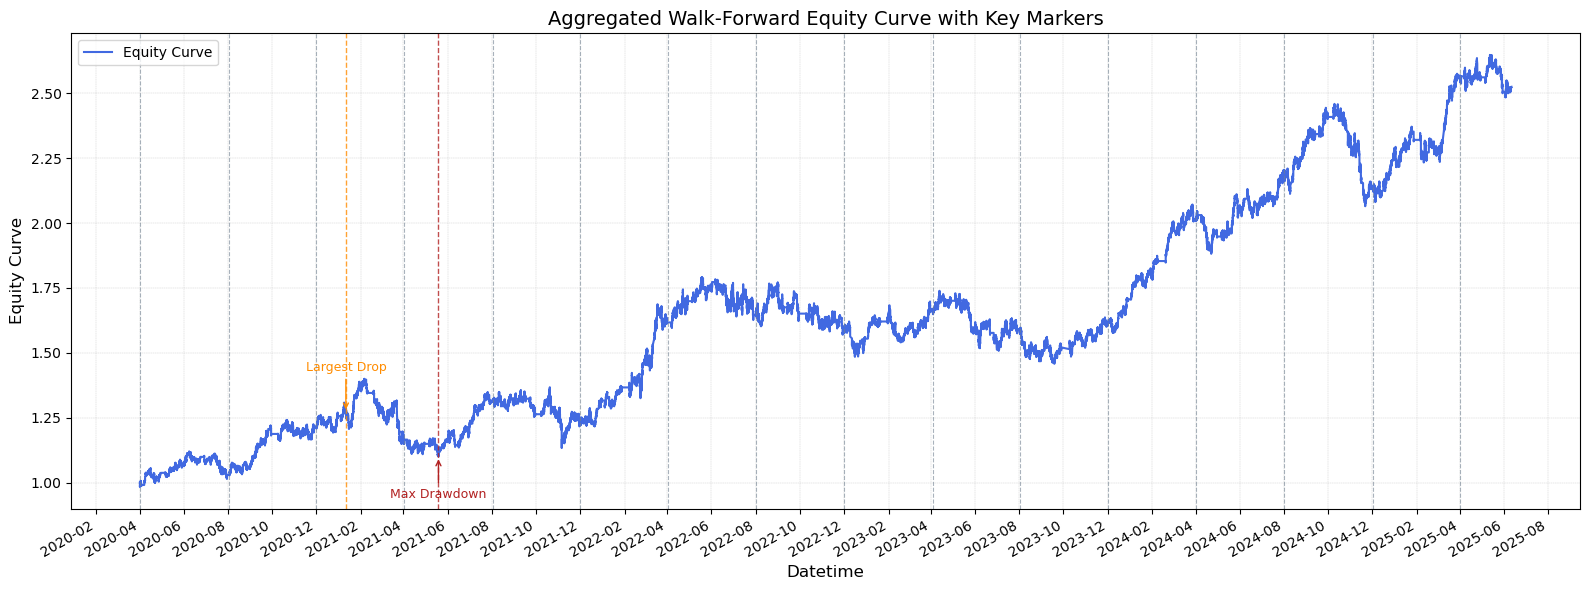

In [46]:
# ================================
# Step 2.6.6 — Plot Aggregated Equity Curve with Annotations
# ================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Compute equity curve from strategy_log_return
combined_df_result["strategy_return"] = np.exp(combined_df_result["strategy_log_return"]) - 1
combined_df_result["equity_curve"] = (1 + combined_df_result["strategy_return"]).cumprod()

# 2. Extract key event timestamps
max_drawdown_time = final_metrics["date_of_max_drawdown"]
max_drop_idx = combined_df_result["strategy_log_return"].idxmin()
max_drop_time = combined_df_result.loc[max_drop_idx, "datetime"]

# 3. Prepare contract boundary transitions
contract_boundaries = (
    combined_df_result[["datetime", "contract_Y_group"]]
    .drop_duplicates("contract_Y_group")
    .sort_values("datetime")
)

# 4. Plot
fig, ax = plt.subplots(figsize=(16, 6))

# Equity curve
ax.plot(
    combined_df_result["datetime"],
    combined_df_result["equity_curve"],
    label="Equity Curve",
    color="royalblue",
    linewidth=1.5
)

# Max drawdown annotation
ax.axvline(max_drawdown_time, color="firebrick", linestyle="--", alpha=0.8, linewidth=1)
ax.annotate("Max Drawdown",
            xy=(max_drawdown_time, combined_df_result.loc[combined_df_result["datetime"] == max_drawdown_time, "equity_curve"].values[0]),
            xytext=(0, -30), textcoords="offset points",
            arrowprops=dict(arrowstyle="->", color="firebrick"),
            ha='center', color="firebrick", fontsize=9)

# Largest single-bar drop
ax.axvline(max_drop_time, color="darkorange", linestyle="--", alpha=0.8, linewidth=1)
ax.annotate("Largest Drop",
            xy=(max_drop_time, combined_df_result.loc[max_drop_idx, "equity_curve"]),
            xytext=(0, 30), textcoords="offset points",
            arrowprops=dict(arrowstyle="->", color="darkorange"),
            ha='center', color="darkorange", fontsize=9)

# Contract boundaries (subtle but more visible lines)
for _, row in contract_boundaries.iterrows():
    ax.axvline(row["datetime"], color="slategray", linestyle="--", linewidth=0.8, alpha=0.6)

# Final plot formatting
ax.set_title("Aggregated Walk-Forward Equity Curve with Key Markers", fontsize=14)
ax.set_ylabel("Equity Curve", fontsize=12)
ax.set_xlabel("Datetime", fontsize=12)
ax.legend(loc="upper left")

# Clean x-axis formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate()

plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.7)
plt.tight_layout()
plt.show()